# Lab 4

This lab will show you how to setup and train classifiers with feed-forward networks. All in JAX of course.

This lab will help you with the next homework, which includes a problem on classification. 

Due: November 24th

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
import time

## Part I: generate samples, create boundary

Suppose we have two classes, each of which is a Gaussian.

$$
P(\vec{x} \mid C_1) \sim {\cal N}(\mu_1,\Sigma) \qquad
P(\vec{x} \mid C_2) \sim {\cal N}(\mu_2,\Sigma)
$$

We know from class and homework 5 that the optimal decision boundary (assuming equal class priors) is the perpendicular bisector connecting the two means.

If $\mu_1 = (0,0)$ and $\mu_2 = (3,0)$, then the decision boundary should be a line parallel to the y-axis located at x=1.5.

In this first part, you will build a deep classifier for the data and see what decision boundary the model has learned.

All data generation is the same as Homework 5.

In Part I you should just run the cells and follow along with the steps. Part II suggests new stuff to try.

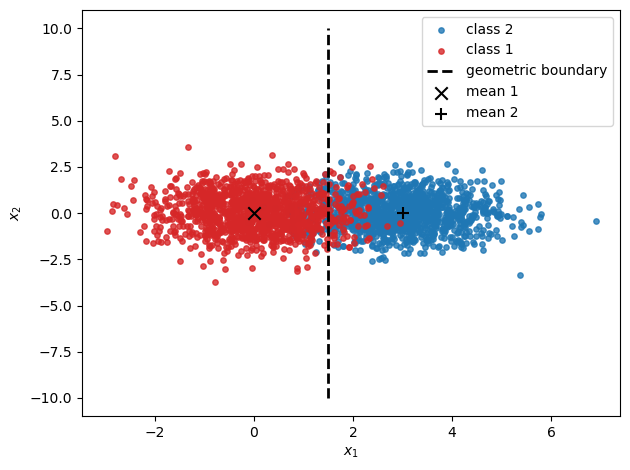

In [4]:
# sample from a 2D Gaussian
def sample_2d_gaussian(mu, Sigma, n, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.multivariate_normal(mean=mu, cov=Sigma, size=n)
    

# data generated with a 2-component Gaussian mixture model (Same as HW 5)

# component weights
w = np.array([0.5, 0.5])

# Gaussian of component 1
mu1      = np.array([0.0, 0.0])
Sigma_1  = np.array([[1.0, 0.0], [0.0, 1.0]])

# Gaussian of component 2
mu2      = np.array([3.0, 0.0])
Sigma_2  = np.array([[1.0, 0.0], [0.0, 1.0]])

# sampling from the ground-truth distribution
N   = 3000
rng = np.random.default_rng(17)

# Step 1: sample the component index
true_labels   = rng.choice([1,2], size=N, p=w)
idx1 = np.where(true_labels==1)[0]
idx2 = np.where(true_labels==2)[0]

# Step 2: sample the Gaussian corresponding to the selected component
X = np.zeros((N,2))
X[idx1] = sample_2d_gaussian(mu1, Sigma_1, len(idx1), rng)
X[idx2] = sample_2d_gaussian(mu2, Sigma_2, len(idx2), rng)

# test/train split of the dataset
X_train, X_test, labels_train, labels_test = train_test_split(X, true_labels, test_size=0.2, random_state=42, stratify=true_labels)

# find out class label indexes
class1_indx = np.where(labels_train==1)
class2_indx = np.where(labels_train==2)

# compute decision boundary (see HW 5)
# the boundary is defined by the points x such that (x - m)·\hat{r} = 0
rhat     = (mu2 - mu1) / np.linalg.norm(mu2 - mu1)
m        = 0.5 * (mu1 + mu2)
v        = np.array([-rhat[1], rhat[0]])
line_pts = np.vstack([m + t*v for t in np.linspace(-10, 10, 200)])

# plot data and boundary
plt.scatter(X_train[class2_indx,0], X_train[class2_indx,1], c='tab:blue', s=15, alpha=0.8, label='class 2')
plt.scatter(X_train[class1_indx,0], X_train[class1_indx,1], c='tab:red', s=15, alpha=0.8, label='class 1')
plt.plot(line_pts[:,0], line_pts[:,1], 'k--', lw=2, label='geometric boundary')
plt.scatter(mu1[0], mu1[1], c='k', marker='x', s=80, label='mean 1')
plt.scatter(mu2[0], mu2[1], c='k', marker='+', s=80, label='mean 2')
plt.legend(loc='best', fontsize=10)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
plt.show()

## Part II: Deep classifier

Here we train a feed-forward NN to classify the data.

Its a 2-layer model with relu activation functions.
We use the standard cross-entropy loss function

In [5]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # must be set before importing jax

import jax
import jax.numpy as jnp
from jax import random

jax.config.update("jax_enable_x64", True)

import optax
from flax import nnx

In [6]:
# make data JAX types. Labels are 0 and 1
y_train_np = labels_train - 1
y_test_np  = labels_test  - 1

X_train_jax = jnp.array(X_train)
X_test_jax  = jnp.array(X_test)
y_train_jax = jnp.array(y_train_np, dtype=jnp.int32)
y_test_jax  = jnp.array(y_test_np,  dtype=jnp.int32)

num_classes = 2
input_dim = 2

In [7]:
class DeepClassifier(nnx.Module):
    """ Deep classifier with 2 hidden layers.
    This classifier predicts un-normalized scores. 
    
    In particular, notice that the model_loss function
    applies a log_softmax, which is what's needed to compute 
    the cross-entropy loss.

    To use this model, one would do...

    sigma = model(x)
    probs = jax.nn.softmax(sigma, axis=-1)   # for P(C_k | x)
    preds = jnp.argmax(sigma, axis=-1)       # for class labels
    """
    
    #def __init__(self, hidden1=32, hidden2=32, *, rngs: nnx.Rngs):
    def __init__(self, hidden1=32, hidden2=32, rngs=None):
        self.d1 = nnx.Linear(input_dim, hidden1, rngs=rngs)
        self.d2 = nnx.Linear(hidden1, hidden2, rngs=rngs)
        self.out = nnx.Linear(hidden2, num_classes, rngs=rngs)

    def __call__(self, x):
        # x: (batch, 2)
        x = self.d1(x)
        x = jax.nn.relu(x)
        x = self.d2(x)
        x = jax.nn.relu(x)
        logits = self.out(x)  # (batch, 2)
        return logits

In [8]:
# defined loss and accuracy
def model_loss(model, x, y):
    """ cross-entropy loss labels 0 and 1 """
    sigma     = model(x)
    log_probs = jax.nn.log_softmax(sigma, axis=-1)
    one_hot   = jax.nn.one_hot(y, num_classes)
    loss      = -jnp.sum(one_hot * log_probs, axis=-1).mean()
    return loss

def accuracy(model, x, y):
    sigma = model(x)
    preds = jnp.argmax(sigma, axis=-1)
    return jnp.mean(preds == y)

In [9]:
# Interlude... what does "one_hot" do?
print(y_train_jax)
print(y_train_jax.shape)
print(jax.nn.one_hot(y_train_jax,2))
print(jax.nn.one_hot(y_train_jax,2).shape)

[1 1 0 ... 0 0 0]
(2400,)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(2400, 2)


In [10]:
# initialize model and optimizer
rngs  = nnx.Rngs(params=jax.random.PRNGKey(0))
model = DeepClassifier(hidden1=32, hidden2=32, rngs=rngs)

# TRY THIS FOR SLOW
#grad_fn = nnx.value_and_grad(model_loss)
# BETTER -- USE THIS FOR SPEED
grad_fn = jax.jit(nnx.value_and_grad(model_loss))

learning_rate = 0.5e-2
sgd           = optax.sgd(learning_rate=learning_rate)
optimizer     = nnx.Optimizer(model, sgd, wrt=nnx.Param)

num_epochs = 200
batch_size = 64
N_train    = X_train_jax.shape[0]

losses_training = []

for epoch in range(num_epochs):
    t0 = time.perf_counter()
    
    # batch shuffle each epoch
    key  = jax.random.PRNGKey(epoch)
    perm = jax.random.permutation(key, N_train)
    X_shuff = X_train_jax[perm]
    y_shuff = y_train_jax[perm]

    epoch_losses = []

    # update over mini-batches
    for start in range(0, N_train, batch_size):
        end = start + batch_size
        xb  = X_shuff[start:end]
        yb  = y_shuff[start:end]

        # optimizer update of parameters
        loss, grads = grad_fn(model, xb, yb)
        optimizer.update(model, grads)
        
        epoch_losses.append(loss)

    loss, grads = grad_fn(model, X_train_jax, y_train_jax)
    losses_training.append(loss)
    t1 = time.perf_counter()
    epoch_time = t1 - t0
    
    # adjust for output frequency
    if (epoch + 1) % 10 == 0:
        train_acc = accuracy(model, X_train_jax, y_train_jax)
        test_acc  = accuracy(model, X_test_jax,  y_test_jax)
        print(f"epoch {epoch+1:3d} | loss {loss:.4f} | train acc {train_acc:.3f} | test acc {test_acc:.3f} | time {epoch_time:.3f} s")         

epoch  10 | loss 0.2839 | train acc 0.898 | test acc 0.902 | time 0.081 s
epoch  20 | loss 0.2287 | train acc 0.908 | test acc 0.910 | time 0.095 s
epoch  30 | loss 0.2090 | train acc 0.914 | test acc 0.920 | time 0.078 s
epoch  40 | loss 0.1981 | train acc 0.918 | test acc 0.922 | time 0.080 s
epoch  50 | loss 0.1904 | train acc 0.920 | test acc 0.922 | time 0.080 s
epoch  60 | loss 0.1846 | train acc 0.925 | test acc 0.925 | time 0.081 s
epoch  70 | loss 0.1802 | train acc 0.928 | test acc 0.923 | time 0.080 s
epoch  80 | loss 0.1765 | train acc 0.929 | test acc 0.925 | time 0.094 s
epoch  90 | loss 0.1738 | train acc 0.929 | test acc 0.932 | time 0.079 s
epoch 100 | loss 0.1718 | train acc 0.929 | test acc 0.935 | time 0.080 s
epoch 110 | loss 0.1704 | train acc 0.930 | test acc 0.935 | time 0.080 s
epoch 120 | loss 0.1692 | train acc 0.930 | test acc 0.935 | time 0.080 s
epoch 130 | loss 0.1683 | train acc 0.930 | test acc 0.937 | time 0.080 s
epoch 140 | loss 0.1676 | train acc 0.

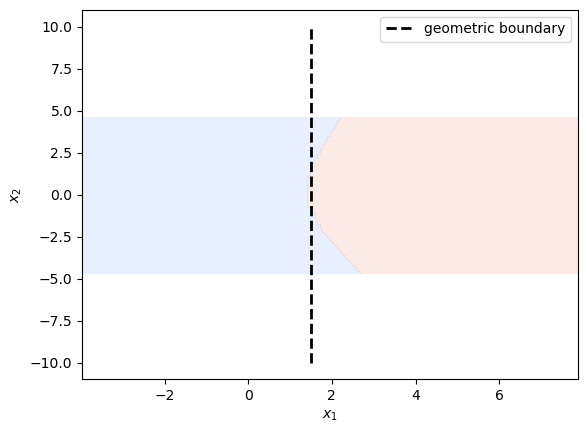

In [11]:
# plot learned decision regions, training data, geometric boundary

# grid up region -- will evaluate the classifier on these grid points
x1_min = X[:, 0].min() - 1.0 
x1_max = X[:, 0].max() + 1.0
x2_min = X[:, 1].min() - 1.0
x2_max = X[:, 1].max() + 1.0
xx1, xx2 = jnp.meshgrid(jnp.linspace(x1_min, x1_max, 200), jnp.linspace(x2_min, x2_max, 200))
grid = jnp.stack([xx1.ravel(), xx2.ravel()], axis=-1)

# evaluate model on grid
preds_grid = jnp.argmax(model(grid), axis=-1).reshape(xx1.shape)

# plot decision regions
plt.contourf(xx1,xx2,preds_grid,levels=[-0.5, 0.5, 1.5],alpha=0.2,cmap='coolwarm')

# training points
#plt.scatter(X_train[class2_indx, 0], X_train[class2_indx, 1], c='blue', s=15, alpha=0.8, label='class 2')
#plt.scatter(X_train[class1_indx, 0], X_train[class1_indx, 1], c='red', s=15, alpha=0.8, label='class 1')

# geometric  boundary
plt.plot(line_pts[:, 0], line_pts[:, 1],'k--', lw=2, label='geometric boundary')

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend(fontsize=10)
plt.show()

## Part III: Deep classifier on new problem

Rerun the problem above, but after applying a non-linear transformation of the x1 and x2 variables. The optimal decision boundary is now much more complicated. 

Try to get the NN classifier to learn this decision boundary. You might need to play around with the optimizer and/or network architecture.

**Your work**: Plot the NN classifier's decision region as was done above

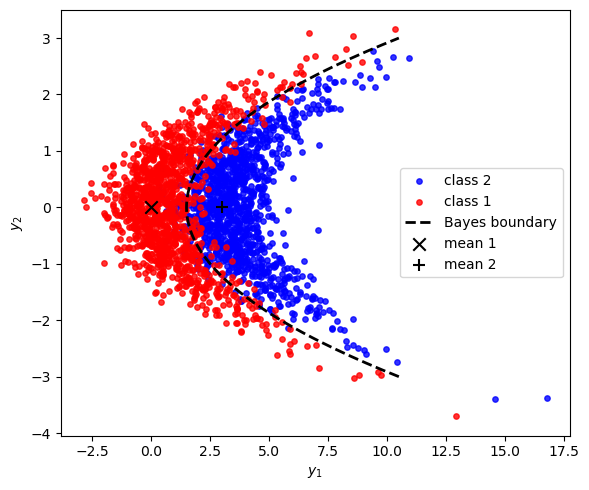

In [13]:
def sample_2d_gaussian(mu, Sigma, n, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.multivariate_normal(mean=mu, cov=Sigma, size=n)

def nonlinear_map(X, alpha):
    x1 = X[:, 0]
    x2 = X[:, 1]
    y1 = x1 + alpha * (x2 ** 2)
    y2 = x2
    return np.stack([y1, y2], axis=1)

# map distortion
alpha = 1.0

# component weights
w = np.array([0.5, 0.5])

# Gaussian of component 1
mu1      = np.array([0.0, 0.0])
Sigma_1  = np.array([[1.0, 0.0], [0.0, 1.0]])

# Gaussian of component 2
mu2      = np.array([3.0, 0.0])
Sigma_2  = np.array([[1.0, 0.0], [0.0, 1.0]])

# sampling from the ground-truth distribution in "x-space"
N   = 3000
rng = np.random.default_rng(17)

# Step 1: sample the component index
true_labels   = rng.choice([1,2], size=N, p=w)
idx1 = np.where(true_labels==1)[0]
idx2 = np.where(true_labels==2)[0]

# Step 2: sample the Gaussian corresponding to the selected component
X_orig = np.zeros((N,2))
X_orig[idx1] = sample_2d_gaussian(mu1, Sigma_1, len(idx1), rng)
X_orig[idx2] = sample_2d_gaussian(mu2, Sigma_2, len(idx2), rng)

# Step 3: apply a nonlinear map to the distributions
X = nonlinear_map(X_orig, alpha=alpha)

# test/train split of the dataset
X_train, X_test, labels_train, labels_test = train_test_split(X, true_labels, test_size=0.2, random_state=17, stratify=true_labels)

# find out class label indexes
class1_indx = np.where(labels_train==1)
class2_indx = np.where(labels_train==2)


# compute decision boundary (see HW 5)
# the boundary is defined by the points x such that (x - m)·\hat{r} = 0
rhat     = (mu2 - mu1) / np.linalg.norm(mu2 - mu1)
m        = 0.5 * (mu1 + mu2)
v        = np.array([-rhat[1], rhat[0]])
x_line   = np.vstack([m + t*v for t in np.linspace(-3, 3, 200)])
line_pts = nonlinear_map(x_line, alpha=alpha) # boundary after nonlinear map

# also map the means
mu1_warp = nonlinear_map(mu1[None, :], alpha=alpha)[0]
mu2_warp = nonlinear_map(mu2[None, :], alpha=alpha)[0]

plt.figure(figsize=(6,5))
plt.scatter(X_train[class2_indx,0], X_train[class2_indx,1], c='blue', s=15, alpha=0.8, label='class 2')
plt.scatter(X_train[class1_indx,0], X_train[class1_indx,1], c='red', s=15, alpha=0.8, label='class 1')

plt.plot(line_pts[:,0], line_pts[:,1], 'k--', lw=2, label='Bayes boundary')

plt.scatter(mu1_warp[0], mu1_warp[1], c='k', marker='x', s=80, label='mean 1')
plt.scatter(mu2_warp[0], mu2_warp[1], c='k', marker='+', s=80, label='mean 2')

plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

## Your job: train the classifier for this dataset

1. copy and paste code from part 1
2. run it.
3. play around with optimizer, hyperparameters, etc
4. try to get a decent network
5. plot the decision regions of the NN-based classifier

Anyone who has a decent classifier should let me know by the end of class!

epoch  20 | loss 0.2530 | train acc 0.925 | test acc 0.943 | time 0.103 s
epoch  40 | loss 0.1967 | train acc 0.922 | test acc 0.935 | time 0.089 s
epoch  60 | loss 0.1074 | train acc 0.928 | test acc 0.940 | time 0.089 s
epoch  80 | loss 0.1251 | train acc 0.924 | test acc 0.947 | time 0.089 s
epoch 100 | loss 0.2298 | train acc 0.918 | test acc 0.943 | time 0.090 s
epoch 120 | loss 0.2315 | train acc 0.928 | test acc 0.942 | time 0.089 s
epoch 140 | loss 0.3362 | train acc 0.923 | test acc 0.938 | time 0.089 s
epoch 160 | loss 0.2133 | train acc 0.923 | test acc 0.942 | time 0.089 s
epoch 180 | loss 0.1700 | train acc 0.928 | test acc 0.937 | time 0.089 s
epoch 200 | loss 0.2060 | train acc 0.923 | test acc 0.938 | time 0.089 s
epoch 220 | loss 0.1901 | train acc 0.929 | test acc 0.945 | time 0.089 s
epoch 240 | loss 0.1736 | train acc 0.930 | test acc 0.948 | time 0.089 s
epoch 260 | loss 0.2484 | train acc 0.928 | test acc 0.930 | time 0.103 s
epoch 280 | loss 0.1488 | train acc 0.

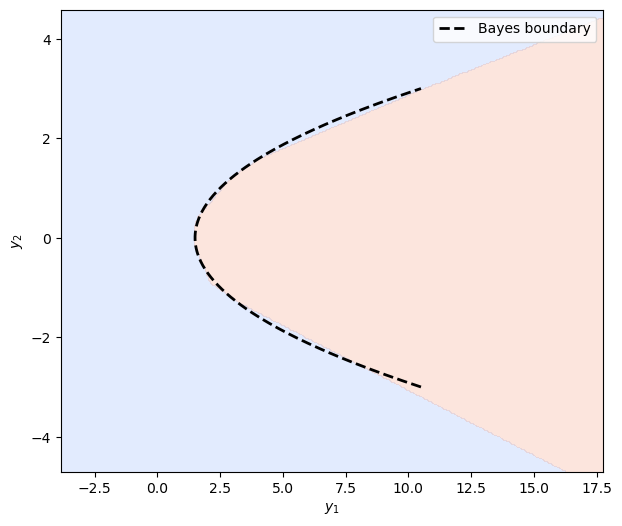

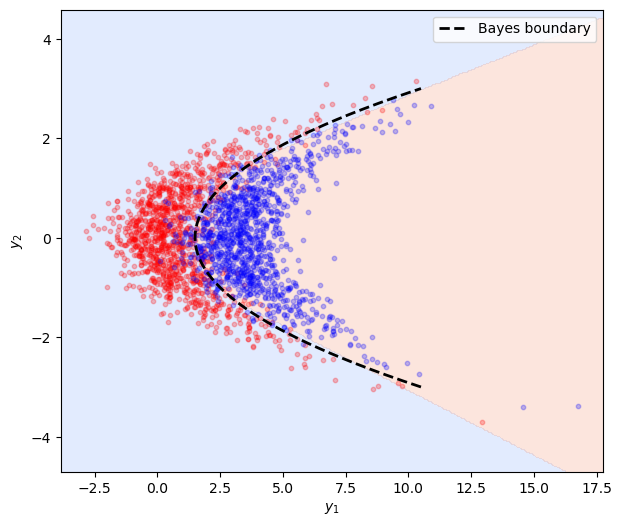

In [43]:
def sample_2d_gaussian(mu, Sigma, n, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    return rng.multivariate_normal(mean=mu, cov=Sigma, size=n)

def nonlinear_map(X, alpha):
    x1 = X[:, 0]
    x2 = X[:, 1]
    y1 = x1 + alpha * (x2 ** 2)
    y2 = x2
    return np.stack([y1, y2], axis=1)

alpha = 1.0
N = 3000
rng = np.random.default_rng(17)

# mixture weights
w = np.array([0.5, 0.5])

mu1 = np.array([0.0, 0.0])
Sigma_1 = np.eye(2)

mu2 = np.array([3.0, 0.0])
Sigma_2 = np.eye(2)

# sample labels
true_labels = rng.choice([1,2], size=N, p=w)

idx1 = np.where(true_labels==1)[0]
idx2 = np.where(true_labels==2)[0]

# sample Gaussian points in x-space
X_orig = np.zeros((N,2))
X_orig[idx1] = sample_2d_gaussian(mu1, Sigma_1, len(idx1), rng)
X_orig[idx2] = sample_2d_gaussian(mu2, Sigma_2, len(idx2), rng)

# apply nonlinear warp
X = nonlinear_map(X_orig, alpha=alpha)

# train/test split
X_train, X_test, labels_train, labels_test = train_test_split(
    X, true_labels, test_size=0.2, random_state=17, stratify=true_labels)

class1_indx = np.where(labels_train==1)[0]
class2_indx = np.where(labels_train==2)[0]

rhat = (mu2 - mu1) / np.linalg.norm(mu2 - mu1)
m    = 0.5 * (mu1 + mu2)
v    = np.array([-rhat[1], rhat[0]])  

x_line = np.vstack([m + t*v for t in np.linspace(-3, 3, 300)])
line_pts = nonlinear_map(x_line, alpha=alpha)

mu1_warp = nonlinear_map(mu1[None,:], alpha=alpha)[0]
mu2_warp = nonlinear_map(mu2[None,:], alpha=alpha)[0]

y_train_np = labels_train - 1
y_test_np  = labels_test  - 1

X_train_jax = jnp.array(X_train)
X_test_jax  = jnp.array(X_test)
y_train_jax = jnp.array(y_train_np, dtype=jnp.int32)
y_test_jax  = jnp.array(y_test_np,  dtype=jnp.int32)

num_classes = 2
input_dim = 2

class DeepClassifier(nnx.Module):
    def __init__(self, hidden1=64, hidden2=64, rngs=None):
        self.d1 = nnx.Linear(input_dim, hidden1, rngs=rngs)
        self.d2 = nnx.Linear(hidden1, hidden2, rngs=rngs)
        self.out = nnx.Linear(hidden2, num_classes, rngs=rngs)

    def __call__(self, x):
        x = jax.nn.relu(self.d1(x))
        x = jax.nn.relu(self.d2(x))
        return self.out(x)

def model_loss(model, x, y):
    sigma = model(x)
    log_probs = jax.nn.log_softmax(sigma, axis=-1)
    one_hot = jax.nn.one_hot(y, num_classes)
    return -(one_hot * log_probs).sum(axis=-1).mean()

def accuracy(model, x, y):
    preds = jnp.argmax(model(x), axis=-1)
    return jnp.mean(preds == y)


# initialize network and optimizer
rngs = nnx.Rngs(params=jax.random.PRNGKey(0))
model = DeepClassifier(hidden1=32, hidden2=32, rngs=rngs)

# adam
optimizer = nnx.Optimizer(model, optax.adam(5e-2), wrt=nnx.Param)
grad_fn = jax.jit(nnx.value_and_grad(model_loss))

# hyperparameters
num_epochs = 400
batch_size = 128
N_train = X_train_jax.shape[0]
#batch_size = N_train

for epoch in range(num_epochs):
    t0 = time.perf_counter()
    key = jax.random.PRNGKey(epoch)
    perm = jax.random.permutation(key, N_train)
    X_shuff = X_train_jax[perm]
    y_shuff = y_train_jax[perm]

    for start in range(0, N_train, batch_size):
        xb = X_shuff[start:start+batch_size]
        ybt = y_shuff[start:start+batch_size]
        loss, grads = grad_fn(model, xb, ybt)
        optimizer.update(model, grads)
        
    t1 = time.perf_counter()   
    epoch_time = t1 - t0
    
    if (epoch+1) % 20 == 0:
        print(f"epoch {epoch+1:3d} | loss {loss:.4f} | "
              f"train acc {accuracy(model, X_train_jax, y_train_jax):.3f} | "
              f"test acc {accuracy(model, X_test_jax, y_test_jax):.3f} | "
              f"time {epoch_time:.3f} s")


# build grid
xx1, xx2 = np.meshgrid(
    np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
    np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300)
)
grid = jnp.stack([xx1.ravel(), xx2.ravel()], axis=-1)

# compute NN probability for class 1
logits = model(grid)
probs = jax.nn.softmax(logits, axis=-1)[:,1].reshape(xx1.shape)

plt.figure(figsize=(7,6))

# filled decision regions
preds_grid = jnp.argmax(logits, axis=-1).reshape(xx1.shape)
plt.contourf(xx1, xx2, preds_grid, levels=[-0.5, 0.5, 1.5], cmap="coolwarm", alpha=0.25)
"""
# NN boundary (computed via contour, plotted via plot())
cs = plt.contour(xx1, xx2, probs, levels=[0.5], colors='none')

paths = cs.get_paths()
if len(paths) > 0:
    verts = paths[0].vertices
    plt.plot(verts[:,0], verts[:,1], 'k', lw=2, label="NN decision boundary")
else:
    print("No decision boundary detected")
"""
# Bayes boundary
plt.plot(line_pts[:,0], line_pts[:,1], 'k--', lw=2, label='Bayes boundary')
"""
# Training points
plt.scatter(X_train[class1_indx,0], X_train[class1_indx,1], c='red', s=10)
plt.scatter(X_train[class2_indx,0], X_train[class2_indx,1], c='blue', s=10)
"""
plt.legend()
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.show()

plt.figure(figsize=(7,6))

# filled decision regions
preds_grid = jnp.argmax(logits, axis=-1).reshape(xx1.shape)
plt.contourf(xx1, xx2, preds_grid, levels=[-0.5, 0.5, 1.5], cmap="coolwarm", alpha=0.25)
"""
# NN boundary (computed via contour, plotted via plot())
cs = plt.contour(xx1, xx2, probs, levels=[0.5], colors='none')

paths = cs.get_paths()
if len(paths) > 0:
    verts = paths[0].vertices
    plt.plot(verts[:,0], verts[:,1], 'k', lw=2, label="NN decision boundary")
else:
    print("No decision boundary detected")
"""
# Bayes boundary
plt.plot(line_pts[:,0], line_pts[:,1], 'k--', lw=2, label='Bayes boundary')

# Training points
plt.scatter(X_train[class1_indx,0], X_train[class1_indx,1], c='red', alpha=0.25, s=10)
plt.scatter(X_train[class2_indx,0], X_train[class2_indx,1], c='blue', alpha=0.25, s=10)

plt.legend()
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.show()